<a href="https://colab.research.google.com/github/bhuvanabasapur/CMPE-258/blob/master/Assignments/Assignment%205/Assignment_5_part_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
import pandas_profiling
import pandas_profiling as pp
from math import sqrt
import requests
from io import BytesIO

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go
%matplotlib inline

# load tqdm
#!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm, tqdm_notebook, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load Data

In [2]:

r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ72HRGTlPQLtJLJpZxV1_UdpnfmkZoGpDS-J5Rm9ecppPpSOcdUN1u5Z-FMk6_LVzbRXUGhQnb0vJd/pub?gid=1290799616&single=true&output=tsv')
data = r.content
df = pd.read_csv(BytesIO(data),sep='\t', index_col=0)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 6918581 to 8424025
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                25000 non-null  object 
 1   fare_amount        25000 non-null  float64
 2   pickup_datetime    25000 non-null  object 
 3   pickup_longitude   25000 non-null  float64
 4   pickup_latitude    25000 non-null  float64
 5   dropoff_longitude  25000 non-null  float64
 6   dropoff_latitude   25000 non-null  float64
 7   passenger_count    25000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.7+ MB


# Data Preprocessing

In [3]:
def haversine_distance(df, lat1, long1, lat2, long2):

    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [4]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [5]:
df.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
6918581,2012-04-20 18:20:00,9.7,2012-04-20 18:20:00 UTC,-73.957867,40.765155,-73.984122,40.759095,4,2.311641,2012-04-20 14:20:00,14,pm,Fri
6135694,2009-12-19 15:43:21,4.1,2009-12-19 15:43:21 UTC,-73.954563,40.780773,-73.961841,40.779553,1,0.627637,2009-12-19 11:43:21,11,am,Sat
38328861,2014-08-17 8:24:36,6.0,2014-08-17 08:24:36 UTC,-73.992020,40.748710,-74.001072,40.755467,2,1.070473,2014-08-17 04:24:36,4,am,Sun
28356410,2011-01-01 13:48:15,7.3,2011-01-01 13:48:15 UTC,-73.973956,40.743322,-73.990257,40.756541,1,2.011497,2011-01-01 09:48:15,9,am,Sat
8634320,2009-12-15 22:33:21,6.9,2009-12-15 22:33:21 UTC,-73.979009,40.761543,-73.996857,40.742475,1,2.599193,2009-12-15 18:33:21,18,pm,Tue


In [6]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']

for col in df.columns:
  if col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])
    df[col]= df[col].astype('category')

# Embedding
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs


[(24, 12), (2, 1), (7, 4)]

In [7]:
Y = df['fare_amount']
df = df[['Hour', 'AMorPM', 'Weekday','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']]

In [8]:
#Normalizing 
from pandas.api.types import is_numeric_dtype

def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])
  return df

df_train = Normalize(df)

In [9]:
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(df_train,
                                                    Y, test_size=0.3, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(17500, 9)
(17500,)
(7500, 9)
(7500,)


# Pytorch

In [10]:
class RegressionColumnarDataset:
    def __init__(self, df, cats, y):
        self.dfcats = df[cats] 
        self.dfconts = df.drop(cats, axis=1) 
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) 
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) 
        self.y = y.values.astype(np.float32)

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [11]:
trainds = RegressionColumnarDataset(X_train, cat_cols, y_train) 
valds = RegressionColumnarDataset(X_val, cat_cols, y_val) 

In [12]:
params = {'batch_size': 128,
          'shuffle': True}

traindl = DataLoader(trainds, **params)
valdl = DataLoader(valds, **params)

In [13]:

# helper functions
from collections.abc import Iterable

def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) 
        self.emb_drop = nn.Dropout(emb_drop) 
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz]
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] 
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) 

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]      
            x = torch.cat(x, 1) 
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) 
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont 
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] 
        return x.squeeze()

In [14]:
y_range = (0, y_train.max()*1.2)
model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)

# Optimizer

In [15]:
from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-2) 

lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

# Train and Fit

In [16]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) 
    

def rmse(targ, y_pred):
   return np.sqrt(mean_squared_error(y_pred, targ)) 


def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() 
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward() 
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
             
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) 
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [17]:
lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 0: train_loss: 6742.6611 train_rmse: 82.1499 | val_loss: 2901.7482 val_rmse: 53.9565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 1: train_loss: 2567.5244 train_rmse: 50.6687 | val_loss: 2842.7882 val_rmse: 53.3948


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 2: train_loss: 758.9892 train_rmse: 27.5758 | val_loss: 97.1366 val_rmse: 9.8602


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 3: train_loss: 73.0088 train_rmse: 8.5403 | val_loss: 59.5708 val_rmse: 7.7031


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 4: train_loss: 62.2434 train_rmse: 7.8952 | val_loss: 53.5040 val_rmse: 7.2816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 5: train_loss: 59.3025 train_rmse: 7.7036 | val_loss: 42.9625 val_rmse: 6.5618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 6: train_loss: 56.2296 train_rmse: 7.5044 | val_loss: 42.6272 val_rmse: 6.5341


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 7: train_loss: 55.8879 train_rmse: 7.4822 | val_loss: 38.2701 val_rmse: 6.1991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 8: train_loss: 52.8519 train_rmse: 7.2737 | val_loss: 43.1366 val_rmse: 6.5813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 9: train_loss: 50.5054 train_rmse: 7.1079 | val_loss: 49.4518 val_rmse: 7.0404


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 10: train_loss: 54.1542 train_rmse: 7.3550 | val_loss: 41.8308 val_rmse: 6.4291


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 11: train_loss: 55.0337 train_rmse: 7.4242 | val_loss: 38.0714 val_rmse: 6.1843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 12: train_loss: 52.7006 train_rmse: 7.2653 | val_loss: 47.8402 val_rmse: 6.9138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 13: train_loss: 56.9165 train_rmse: 7.5465 | val_loss: 51.9077 val_rmse: 7.1790


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 14: train_loss: 52.9347 train_rmse: 7.2799 | val_loss: 53.6525 val_rmse: 7.3329


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 15: train_loss: 55.0872 train_rmse: 7.4176 | val_loss: 46.9790 val_rmse: 6.8570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 16: train_loss: 53.2438 train_rmse: 7.3003 | val_loss: 36.1394 val_rmse: 6.0226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 17: train_loss: 51.5061 train_rmse: 7.1803 | val_loss: 42.9334 val_rmse: 6.5303


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 18: train_loss: 53.9183 train_rmse: 7.3472 | val_loss: 41.0471 val_rmse: 6.4085


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 19: train_loss: 51.7794 train_rmse: 7.0629 | val_loss: 41.2489 val_rmse: 6.3952


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 20: train_loss: 53.4755 train_rmse: 7.3061 | val_loss: 43.0609 val_rmse: 6.5700


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 21: train_loss: 52.4524 train_rmse: 7.2474 | val_loss: 39.1440 val_rmse: 6.2462


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 22: train_loss: 106.7853 train_rmse: 10.3274 | val_loss: 172.6610 val_rmse: 13.1549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 23: train_loss: 101.0434 train_rmse: 10.0508 | val_loss: 54.8577 val_rmse: 7.4136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 24: train_loss: 57.7975 train_rmse: 7.6036 | val_loss: 46.4110 val_rmse: 6.8289


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 25: train_loss: 54.8005 train_rmse: 7.4028 | val_loss: 39.0349 val_rmse: 6.2542


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 26: train_loss: 51.9006 train_rmse: 7.2021 | val_loss: 41.7860 val_rmse: 6.4330


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 27: train_loss: 50.9358 train_rmse: 7.1352 | val_loss: 40.2532 val_rmse: 6.3488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 28: train_loss: 48.6832 train_rmse: 6.9782 | val_loss: 39.8954 val_rmse: 6.3165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 29: train_loss: 54.8240 train_rmse: 7.4084 | val_loss: 54.1911 val_rmse: 7.3786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 30: train_loss: 55.9584 train_rmse: 7.4861 | val_loss: 39.3345 val_rmse: 6.2612


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 31: train_loss: 48.7501 train_rmse: 6.9828 | val_loss: 37.8220 val_rmse: 6.1609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 32: train_loss: 49.3015 train_rmse: 7.0262 | val_loss: 41.9727 val_rmse: 6.4809


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 33: train_loss: 51.1991 train_rmse: 7.1610 | val_loss: 39.9798 val_rmse: 6.3192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 34: train_loss: 49.6327 train_rmse: 7.0359 | val_loss: 41.4089 val_rmse: 6.4154


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 35: train_loss: 50.5528 train_rmse: 7.1114 | val_loss: 39.7110 val_rmse: 6.2925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 36: train_loss: 47.7691 train_rmse: 6.9027 | val_loss: 39.6365 val_rmse: 6.3114


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 37: train_loss: 49.4970 train_rmse: 7.0319 | val_loss: 43.0131 val_rmse: 6.5673


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 38: train_loss: 47.6328 train_rmse: 6.9039 | val_loss: 38.2787 val_rmse: 6.1996


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 39: train_loss: 47.4034 train_rmse: 6.8848 | val_loss: 36.6751 val_rmse: 6.0300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 40: train_loss: 48.6203 train_rmse: 6.9785 | val_loss: 35.1812 val_rmse: 5.9421


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 41: train_loss: 48.7262 train_rmse: 6.9788 | val_loss: 32.3686 val_rmse: 5.6984


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 42: train_loss: 48.2455 train_rmse: 6.9476 | val_loss: 35.5640 val_rmse: 5.9631


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 43: train_loss: 49.1384 train_rmse: 7.0122 | val_loss: 42.5998 val_rmse: 6.5203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 44: train_loss: 52.5806 train_rmse: 7.2524 | val_loss: 39.3058 val_rmse: 6.2748


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 45: train_loss: 48.3170 train_rmse: 6.9557 | val_loss: 44.4937 val_rmse: 6.6691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 46: train_loss: 48.7712 train_rmse: 6.9849 | val_loss: 36.9575 val_rmse: 6.0933


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 47: train_loss: 56.4358 train_rmse: 7.5095 | val_loss: 40.9855 val_rmse: 6.4129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 48: train_loss: 54.6824 train_rmse: 7.3972 | val_loss: 38.1911 val_rmse: 6.1908


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 49: train_loss: 51.2407 train_rmse: 7.1592 | val_loss: 44.3428 val_rmse: 6.6483


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 50: train_loss: 50.8915 train_rmse: 7.1394 | val_loss: 41.7756 val_rmse: 6.4714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 51: train_loss: 47.2658 train_rmse: 6.8740 | val_loss: 39.8197 val_rmse: 6.3209


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 52: train_loss: 50.6775 train_rmse: 7.1222 | val_loss: 37.5995 val_rmse: 6.1242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 53: train_loss: 53.8235 train_rmse: 7.3410 | val_loss: 43.4688 val_rmse: 6.6115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 54: train_loss: 50.0687 train_rmse: 7.0791 | val_loss: 33.7438 val_rmse: 5.8229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 55: train_loss: 45.2492 train_rmse: 6.7315 | val_loss: 36.5664 val_rmse: 6.0550


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 56: train_loss: 44.1365 train_rmse: 6.6447 | val_loss: 34.4552 val_rmse: 5.8811


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 57: train_loss: 44.8508 train_rmse: 6.6857 | val_loss: 33.8262 val_rmse: 5.8262


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 58: train_loss: 42.7132 train_rmse: 6.5345 | val_loss: 32.6214 val_rmse: 5.7157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 59: train_loss: 38.9895 train_rmse: 6.2486 | val_loss: 27.4403 val_rmse: 5.2400


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 60: train_loss: 38.2875 train_rmse: 6.1904 | val_loss: 26.3683 val_rmse: 5.1293


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 61: train_loss: 35.6157 train_rmse: 5.9715 | val_loss: 27.3654 val_rmse: 5.2384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 62: train_loss: 35.3755 train_rmse: 5.9486 | val_loss: 26.9280 val_rmse: 5.1900


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 63: train_loss: 33.2480 train_rmse: 5.7665 | val_loss: 21.8529 val_rmse: 4.6834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 64: train_loss: 33.6089 train_rmse: 5.8011 | val_loss: 22.6990 val_rmse: 4.7711


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 65: train_loss: 33.6810 train_rmse: 5.7989 | val_loss: 22.9773 val_rmse: 4.8034


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 66: train_loss: 34.0059 train_rmse: 5.8289 | val_loss: 25.9259 val_rmse: 5.1037


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 67: train_loss: 34.2780 train_rmse: 5.8578 | val_loss: 24.5475 val_rmse: 4.9646


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 68: train_loss: 32.6057 train_rmse: 5.7142 | val_loss: 23.3828 val_rmse: 4.8437


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 69: train_loss: 32.0904 train_rmse: 5.6649 | val_loss: 26.5820 val_rmse: 5.1587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 70: train_loss: 33.7061 train_rmse: 5.8028 | val_loss: 24.2082 val_rmse: 4.9277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 71: train_loss: 31.4019 train_rmse: 5.6065 | val_loss: 24.0080 val_rmse: 4.9076


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 72: train_loss: 32.6953 train_rmse: 5.7167 | val_loss: 24.0361 val_rmse: 4.9127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 73: train_loss: 32.2545 train_rmse: 5.6820 | val_loss: 27.9470 val_rmse: 5.2713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 74: train_loss: 32.3212 train_rmse: 5.6873 | val_loss: 22.4000 val_rmse: 4.7381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 75: train_loss: 32.6089 train_rmse: 5.7039 | val_loss: 22.5245 val_rmse: 4.7441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 76: train_loss: 32.3390 train_rmse: 5.6893 | val_loss: 23.5481 val_rmse: 4.8615


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 77: train_loss: 32.2178 train_rmse: 5.6793 | val_loss: 23.5817 val_rmse: 4.8667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 78: train_loss: 31.3620 train_rmse: 5.6041 | val_loss: 29.5666 val_rmse: 5.4410


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 79: train_loss: 30.9098 train_rmse: 5.5609 | val_loss: 22.9551 val_rmse: 4.7927


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 80: train_loss: 30.7794 train_rmse: 5.5465 | val_loss: 21.3267 val_rmse: 4.6091


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 81: train_loss: 31.8553 train_rmse: 5.6468 | val_loss: 22.4131 val_rmse: 4.7443


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 82: train_loss: 32.6562 train_rmse: 5.7178 | val_loss: 23.6757 val_rmse: 4.8629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 83: train_loss: 31.2854 train_rmse: 5.5955 | val_loss: 26.7666 val_rmse: 5.1710


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 84: train_loss: 30.2458 train_rmse: 5.4983 | val_loss: 21.8742 val_rmse: 4.6775


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 85: train_loss: 30.8579 train_rmse: 5.5581 | val_loss: 22.8410 val_rmse: 4.7741


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 86: train_loss: 33.6920 train_rmse: 5.8034 | val_loss: 26.1731 val_rmse: 5.1246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 87: train_loss: 32.5838 train_rmse: 5.7105 | val_loss: 25.1837 val_rmse: 5.0032


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 88: train_loss: 30.8123 train_rmse: 5.5530 | val_loss: 23.0978 val_rmse: 4.8152


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 89: train_loss: 30.6591 train_rmse: 5.5233 | val_loss: 22.4355 val_rmse: 4.7458


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 90: train_loss: 33.1342 train_rmse: 5.7611 | val_loss: 22.3145 val_rmse: 4.7346


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 91: train_loss: 32.0966 train_rmse: 5.6683 | val_loss: 31.4783 val_rmse: 5.6188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 92: train_loss: 33.6090 train_rmse: 5.7994 | val_loss: 31.0565 val_rmse: 5.5698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 93: train_loss: 34.4103 train_rmse: 5.8612 | val_loss: 23.4757 val_rmse: 4.8525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 94: train_loss: 32.0371 train_rmse: 5.6620 | val_loss: 23.7217 val_rmse: 4.8805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 95: train_loss: 32.7513 train_rmse: 5.7234 | val_loss: 24.7713 val_rmse: 4.9805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 96: train_loss: 32.5374 train_rmse: 5.6975 | val_loss: 22.7082 val_rmse: 4.7673


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 97: train_loss: 31.7264 train_rmse: 5.6351 | val_loss: 22.9161 val_rmse: 4.7951


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 98: train_loss: 31.5626 train_rmse: 5.6123 | val_loss: 25.7986 val_rmse: 5.0687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 99: train_loss: 31.3539 train_rmse: 5.5947 | val_loss: 24.2119 val_rmse: 4.9201



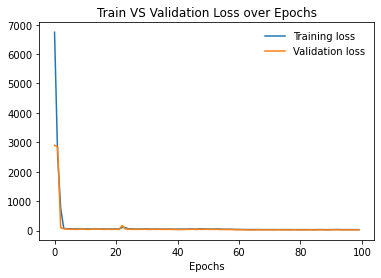

In [18]:
t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)

Reference:

https://github.com/offirinbar/NYC_Taxi/blob/master/NYC_Taxi_PyTorch.ipynb